# Convolutional Neural Network Modeling
---

To run this notebook, you need to have the Tensorflow package installed. It might be best to set up a virtual environment for this, but you can read more in the [Tensorflow documentation](https://www.tensorflow.org/install)

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# For reproducibility
np.random.seed(42)

---
### Importing the data

The function below does the following:

- Creates a list to store array representations of images from a given class
- Normalizes the array values
- Adds the normalized array to the array list
- Prints an error message for files that could not be converted
- Converts the lists to a numpy array representation for compatibility with keras

In [2]:
data_path = '../data/'

In [3]:
# Create a function to turn images into arrays
def process_images(folder_list):
    arrays = []
    
    for folder in folder_list:
    
        path = data_path + folder

        for file in os.listdir(path):
            if not file.startswith('.'):
                try:
                    image = load_img(path + file)

                    # normalize the arrays to get values to be less than 1
                    image_array = img_to_array(image) / 255
                    arrays.append(image_array)

                except:
                    print(f'Error for file: {file}')

    print(f'{len(arrays)} pictures converted in total.')
    return arrays

In [4]:
folders_cor_mask = ['04000/', '05000/', '06000/']
cor_mask = process_images(folders_cor_mask)

2907 pictures converted in total.


In [5]:
folders_no_mask = ['09000/', '10000/', '11000/']
no_mask = process_images(folders_no_mask)

3000 pictures converted in total.


In [6]:
folders_inc_mask =  ['13000/', '14000/', '15000/']
inc_mask = process_images(folders_inc_mask)

2877 pictures converted in total.


We can see here that our total number of images in each class isn't quite equal, but we have more than enough data from each class to continue. The code below merges all of the arrays together so that we can pass them to a model.

In [7]:
# Create X var with our image arrays
X = no_mask + cor_mask + inc_mask

# convert to array and check shape
X = np.array(X)
print(f'X shape: {X.shape}')

# Create y var for our target
# 0 for unmasked, 1 for correct masked, 2 for incorrectly masked
y = [0] * len(no_mask) + [1] * len(cor_mask) + [2] * len(inc_mask)
y = to_categorical(y)

# convert to array and check shape
y = np.array(y)
print(f'y shape: {y.shape}')

X shape: (8784, 256, 256, 3)
y shape: (8784, 3)


---
### Train-test splitting

We need to split our data into training and testing samples for model validation. We have 3 classes, about equally represented, and we can stratify on y to preserve that representation.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Make sure that these training and testing sets are arrays, because that's the format our model will be looking for.

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)

Let's check the shapes of our X_train and y_train to ensure things look good.

In [10]:
X_train.shape

(6588, 256, 256, 3)

In [11]:
y_train.shape

(6588, 3)

The input layer of our model should have an input shape of (256, 256, 3), because this is the size of a single image's array. This translates to 256 pixels by 256 pixels by 3 color channels (red, green, and blue). 

---
### Building a Convolutional Neural Network



### A discussion of our neural network structure:

We went through a few different iterations of model building before settling on a relatively simple neural network.

##### Convolution Layers

We originally had two convolutional layers that were both 64 nodes, and our computers had quite a time with this; so did Google Colab. The resulting models were incredibly accurate, but it appeared to be overkill in the situation. We eventually went with two convolutional layers with 16 nodes each as these were roughly as accurate while being a fraction of the computational expense. We found that working with fewer nodes, but more epochs wound up being just as accurate as more nodes and fewer epochs.

##### Pooling Layers

We included pooling layers after each convolutional layer, as this helps to reduce data dimensionality and protects against overfitting.

##### Output Layer

We have three nodes for our output layer as we are attempting to predict for three possible outcomes.

##### Hyperparameter Tuning

We were unable to perform a gridsearch to tune hyperparameters for our model because running neural networks on a dataset of 9,000 images takes a considerable amount of computing power. Ideally, hyperparameters that we would have tuned here include the number of layers, the size of the Conv2D and MaxPooling2D filters, and the number of nodes for each layer. 

##### Baseline Model

Our baseline model is around 34% (3000/8784) using our majority class, which is the 'no mask' class. This is the baseline accuracy we're hoping to beat! 

In [12]:
input_shape = (256,256,3) # equal to X_train[0].shape
model = Sequential()

# two rounds of feature selection and pooling
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# a plain dense layer needs the flat format because it can't handle a matrix
model.add(Flatten())
model.add(Dense(16, activation='relu'))

# output layer
model.add(Dense(3, activation='softmax'))

# compile the model
model.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# fit the model and get results
results = model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
         epochs=25,
         batch_size=64,
         verbose=0)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                984080    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 5

The printout above shows us that this model has a total of 986,899 trainable parameters! Even after simplifying our model, there's still an astronomical amount of work going on behind the scenes here. Next, we can get predictions and start looking at some of those evaluation metrics we included in the compile step.

If you'd like to run the rest of the notebook without training this model from scratch, you can load it in using the cell below.

In [18]:
# model = load_model('../mask_model.h5')

In [16]:
preds = model.predict(X_test)

In [17]:
preds[:5]

array([[9.9999833e-01, 2.0678180e-19, 1.6835723e-06],
       [8.3883301e-17, 2.6376311e-11, 1.0000000e+00],
       [1.0000000e+00, 3.8517058e-27, 1.7145709e-09],
       [9.9999416e-01, 4.0185086e-19, 5.8099040e-06],
       [1.7780365e-12, 2.4033433e-09, 1.0000000e+00]], dtype=float32)

Checking just one prediction, our model outputs a list of fractions. These fractions represent 

In [19]:
train_loss = results.history['loss']
test_loss = results.history['val_loss']
train_acc = results.history['acc']
test_acc = results.history['val_acc']

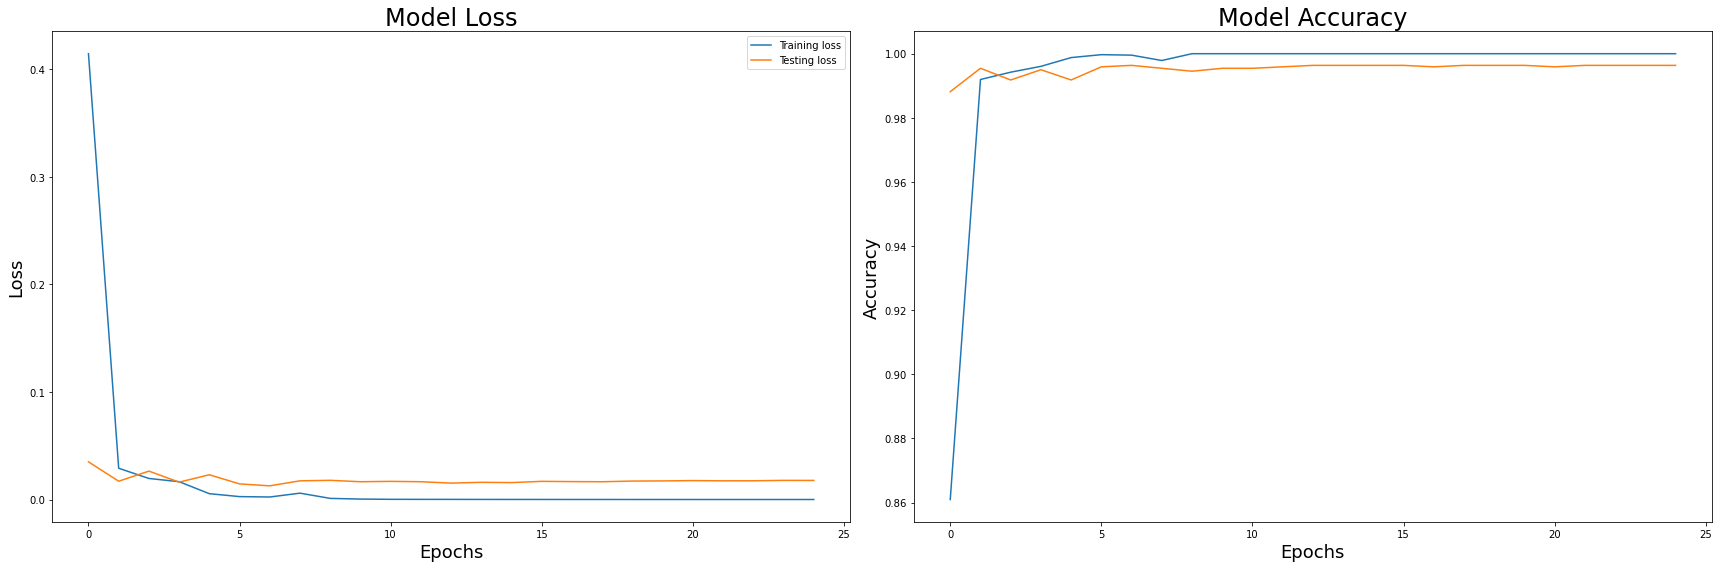

In [20]:
# Visualize the loss and accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Plot loss
ax1.set_title('Model Loss', size=24)
ax1.set_xlabel('Epochs', size=18)
ax1.set_ylabel('Loss', size=18)

ax1.plot(train_loss, label='Training loss')
ax1.plot(test_loss, label='Testing loss')

# Plot accuracy
ax2.set_title('Model Accuracy', size=24)
ax2.set_xlabel('Epochs', size=18)
ax2.set_ylabel('Accuracy', size=18)

ax2.plot(train_acc, label='Training accuracy')
ax2.plot(test_acc, label='Testing accuracy')

ax1.legend()

plt.tight_layout()
plt.savefig('../figures/loss_acc.png')

In [21]:
train_prec = results.history['precision']
test_prec = results.history['val_precision']

train_rec = results.history['recall']
test_rec = results.history['val_recall']

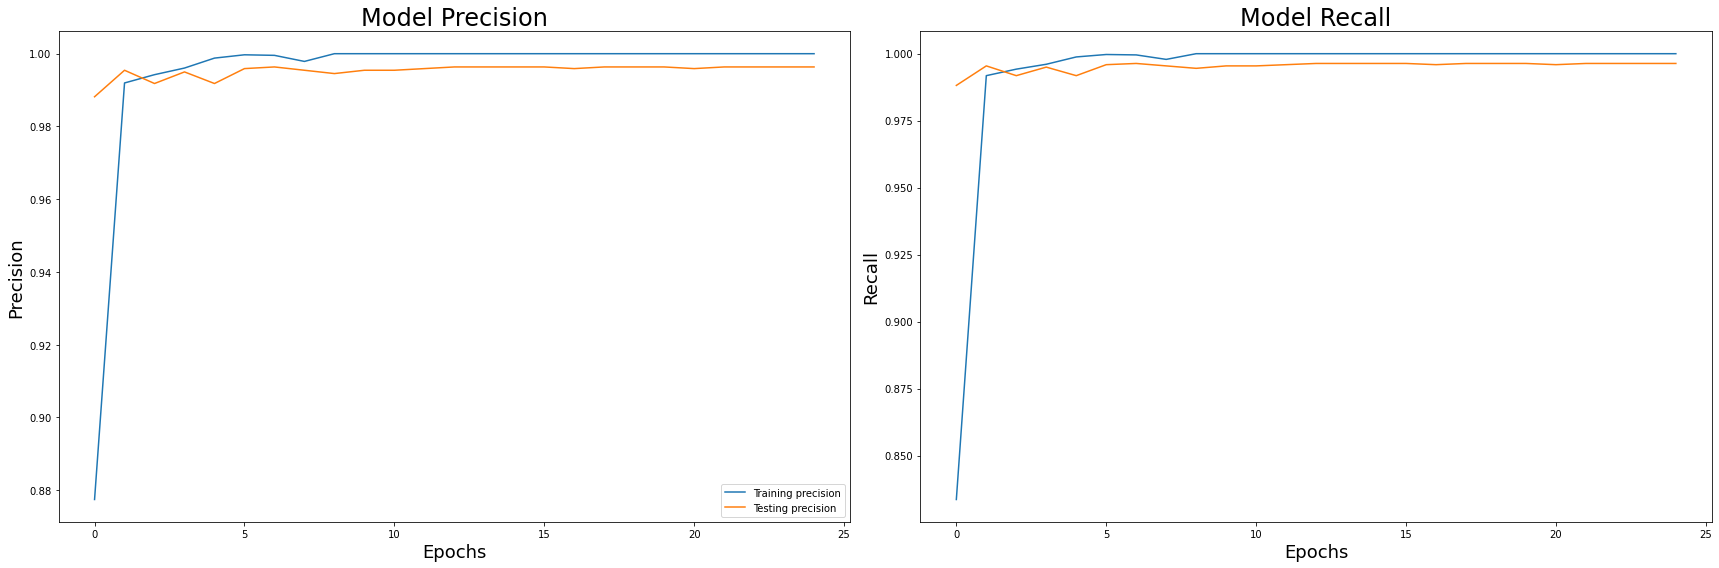

In [22]:
# Visualize the loss and accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Plot loss
ax1.set_title('Model Precision', size=24)
ax1.set_xlabel('Epochs', size=18)
ax1.set_ylabel('Precision', size=18)

ax1.plot(train_prec, label='Training precision')
ax1.plot(test_prec, label='Testing precision')

# Plot accuracy
ax2.set_title('Model Recall', size=24)
ax2.set_xlabel('Epochs', size=18)
ax2.set_ylabel('Recall', size=18)

ax2.plot(train_rec, label='Training recall')
ax2.plot(test_rec, label='Testing recall')

ax1.legend()

plt.tight_layout()
plt.savefig('../figures/prec_rec.png')

The below code turns our array of fractional predictions and `y_test` array into lists of integer representations of our three classes. This transformation will let us easily view our model predictions and misclassifications in a confusion matrix. 

In [23]:
y_pred = [np.argmax(y, axis=None, out=None) for y in preds]
y_true = [np.argmax(y, axis=None, out=None) for y in y_test]

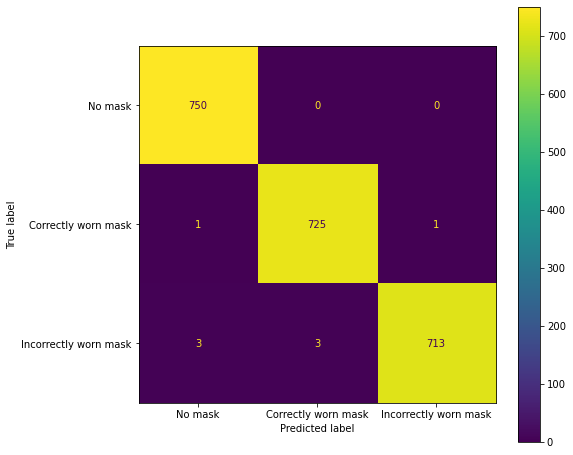

In [24]:
labels = ['No mask', 'Correctly worn mask', 'Incorrectly worn mask']

fig, ax = plt.subplots(figsize=(8,8))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax);

This model made very few misclassifications! It'd be interesting to explore which images it misclassified and try to see what it gets confused by.

In [25]:
print(f'{100 * y_pred.count(0) / len(y_pred)}% of predictions were of no mask.')
print(f'{100 * y_pred.count(1) / len(y_pred)}% of predictions were of correctly worn masks.')
print(f'{100 * y_pred.count(2) / len(y_pred)}% of predictions were of incorrectly worn masks.')

34.3351548269581% of predictions were of no mask.
33.1511839708561% of predictions were of correctly worn masks.
32.513661202185794% of predictions were of incorrectly worn masks.


We can save this model and use it in our live feed script! Change the name below if you want to save multiple models without overwriting the previous one.

In [26]:
model.save('../mask_model.h5')

That's all we've got for you! Feel free to try out the live video classification on your own! 